In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DayLocator, DateFormatter
from SPARQLWrapper import SPARQLWrapper, JSON
import datetime

In [12]:
pip install SPARQLWrapper

Note: you may need to restart the kernel to use updated packages.


In [13]:
def sparql_to_dataframe(endpoint, query):
    """
    Convert SPARQL results into a Pandas DataFrame.
    Credit: https://lawlesst.github.io/notebook/sparql-dataframe.html
    """
    sparql = SPARQLWrapper(endpoint)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    results = sparql.queryAndConvert()

    cols = results['head']['vars']
    out = []
    for row in results['results']['bindings']:
        item = []
        for c in cols:
            item.append(row.get(c, {}).get('value'))
        out.append(item)

    return pd.DataFrame(out, columns=cols)


In [14]:
def preprocess_df(df):
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
    df.precipitation = df.precipitation.astype(float)
    df = df.sort_values(by='date')
    #df.set_index('date',inplace=True)
    return df

In [15]:
Virtuoso = 'http://localhost:8890/sparql'

## 1. Retrieve daily precipitations across Years

This SPARQL query allows to retrieve daily cumulative precipitations measured at the '''Bordeaux-Merignac''' weather station during three years 2019, 2020 and 2021. We plot obtained values to enable experts to compare daily precipitations for the same period at a given place.


In [16]:
query_precip = '''
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX sosa: <http://www.w3.org/ns/sosa/>
PREFIX qudt: <http://qudt.org/schema/qudt/>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
prefix wep: <http://ns.inria.fr/meteo/ontology/property/>
prefix weo: <http://ns.inria.fr/meteo/ontology/>
prefix dct: <http://purl.org/dc/terms/>
prefix wdt: <http://www.wikidata.org/prop/direct/>
select ?date (?vt as ?precipitation)   
FROM <http://ns.inria.fr/meteo/observation/2020>
FROM <http://ns.inria.fr/meteo/observation/2019>
FROM <http://ns.inria.fr/meteo/observation/2021>
FROM <http://ns.inria.fr/meteo/weatherstation>
where      
  {

    { 
      ?obs a  <http://ns.inria.fr/meteo/ontology/MeteorologicalObservation> .
      ?obs sosa:observedProperty <http://ns.inria.fr/meteo/vocab/weatherproperty/precipitationAmount>.
      ?obs sosa:hasSimpleResult ?vt.
      ?obs sosa:resultTime ?datetimestamp.
      ?obs wep:madeByStation ?x .
      FILTER(strEnds(str(?datetimestamp), "T00:00:00"^^xsd:string))
      FILTER(?datetimestamp > "2019-01-01T00:00:00"^^xsd:dateTime )
      FILTER (str(?x) = "http://ns.inria.fr/meteo/weatherstation/07510").
      BIND(xsd:date(?datetimestamp) as ?date)
    } 
    
    GRAPH <http://ns.inria.fr/meteo/weatherstation> 
     {
     ?x rdfs:label ?Station ;  weo:stationID ?stationID .
     }

  } 
'''



In [19]:
rainfallY = preprocess_df(sparql_to_dataframe(Virtuoso, query_precip))


In [20]:
def get_days_since_jan1(date):
    return date.timetuple().tm_yday - 1

def split_data_by_year(weather):
    yearly_rainfall = []
    yearly_days_since_jan1 = []
    current_year = None
    by_year = []
    for i, row in weather.iterrows():
        date = row['date']
        rainfall = row['precipitation']

        if current_year is None:
            current_year = date.year
        elif current_year != date.year:
            by_year.append((current_year, pd.DataFrame({
                'days_since_jan1': yearly_days_since_jan1,
                'rainfall': yearly_rainfall,
                })))
            yearly_days_since_jan1 = []
            yearly_rainfall = []
            current_year = date.year

        yearly_rainfall.append(rainfall)
        yearly_days_since_jan1.append(get_days_since_jan1(date))

    if current_year is not None:
        by_year.append((current_year, pd.DataFrame({
            'days_since_jan1': yearly_days_since_jan1,
            'rainfall': yearly_rainfall,
            })))
    return by_year

In [21]:
rainfall_by_year = split_data_by_year(rainfallY)

In [22]:
rainfall_by_year

[(2019,
       days_since_jan1  rainfall
  0                  1       0.0
  1                  2       0.0
  2                  3       0.0
  3                  4       0.0
  4                  5       0.0
  ..               ...       ...
  357              360      -0.1
  358              361       0.0
  359              362       0.0
  360              363       0.0
  361              364       0.0
  
  [362 rows x 2 columns]),
 (2020,
       days_since_jan1  rainfall
  0                  0       0.0
  1                  1      -0.1
  2                  2       0.0
  3                  3       1.6
  4                  4       0.0
  ..               ...       ...
  359              361      -0.1
  360              362      25.1
  361              363      17.7
  362              364       3.0
  363              365       8.4
  
  [364 rows x 2 columns]),
 (2021,
       days_since_jan1  rainfall
  0                  0      18.0
  1                  1       6.2
  2                  2   

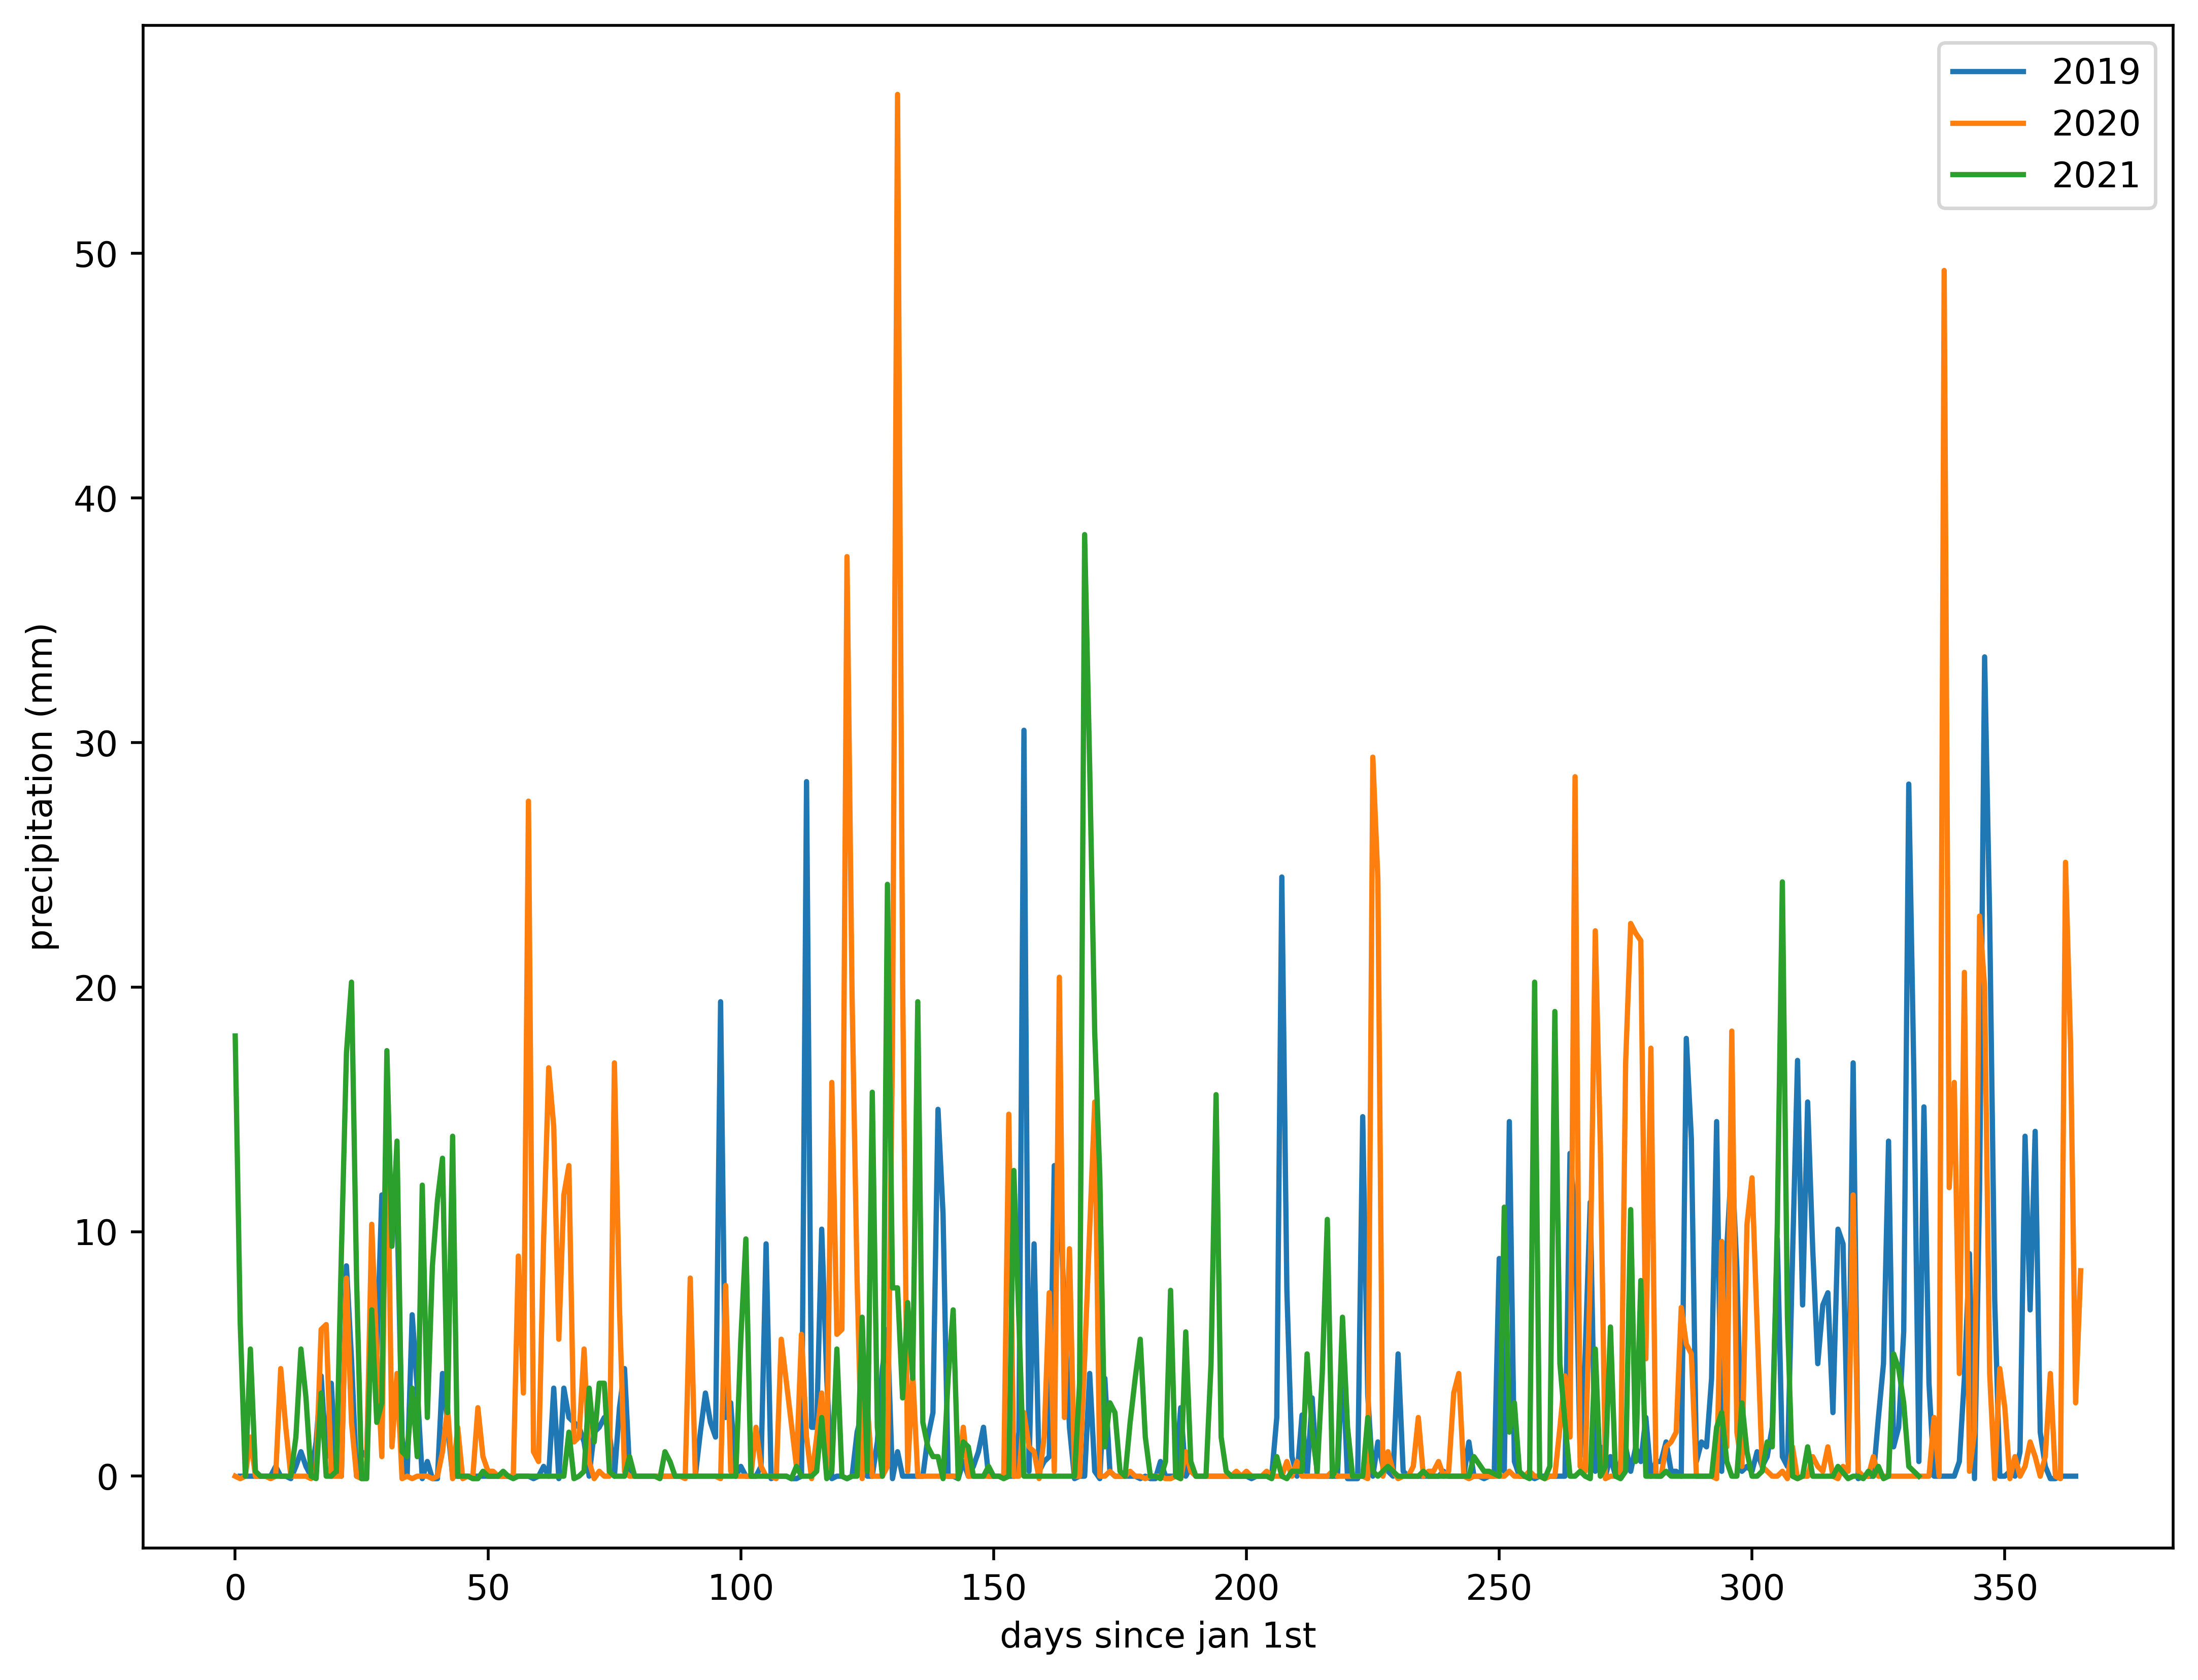

In [23]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 6), dpi=500)
ax = fig.add_axes([0, 0, 1, 1])

for year, annual_data in rainfall_by_year:
    days_since_jan1 = annual_data['days_since_jan1'].to_list()
    rainfall = annual_data['rainfall'].to_list()
    ax.plot(days_since_jan1, rainfall, label=year)

# label the axes and title the plot
ax.set_xlabel('days since jan 1st')
ax.set_ylabel('precipitation (mm)')
#ax.set_title(' daily precipitation since Jan 1st (STATION BORDEAUX-MERIGNAC)')

ax.legend()

# save the plot to disk
fig.savefig('daily-precipitation-by-year.png', bbox_inches='tight')

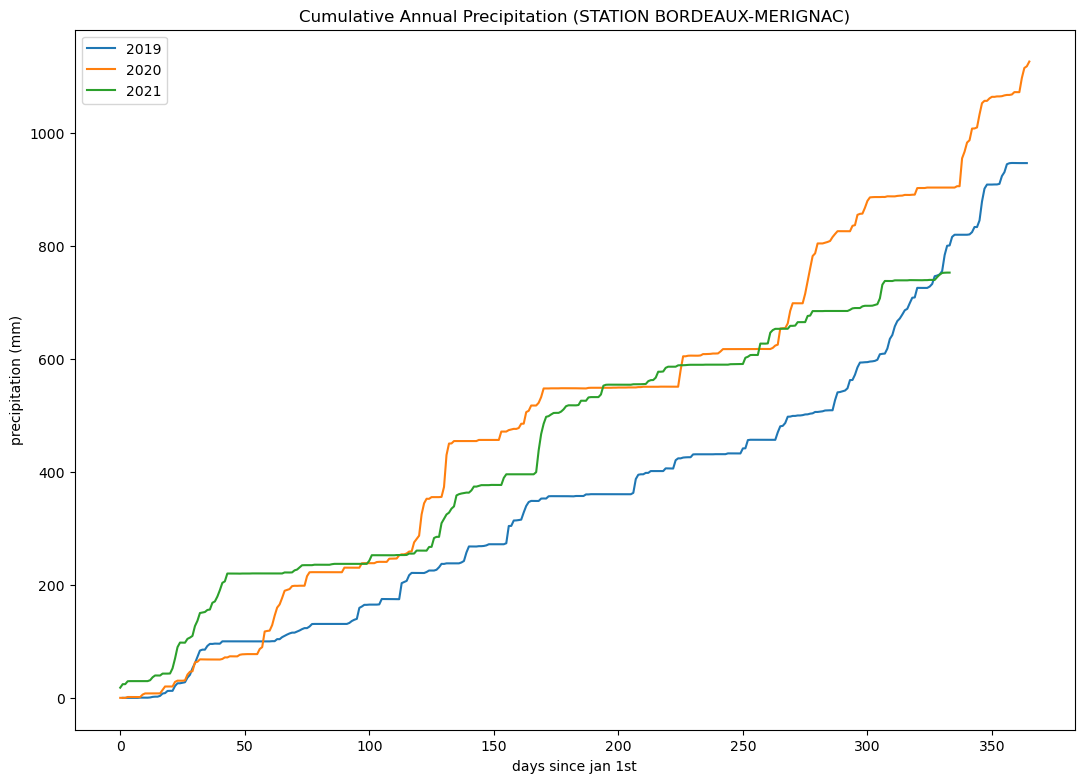

In [24]:
fig = plt.figure(figsize=(10.0, 7.0), dpi=100)
ax = fig.add_axes([0, 0, 1, 1])

for year, annual_data in rainfall_by_year:
    days_since_jan1 = annual_data['days_since_jan1'].to_list()
    rainfall = annual_data['rainfall'].cumsum().to_list()
    ax.plot(days_since_jan1, rainfall, label=year)

# label the axes and title the plot
ax.set_xlabel('days since jan 1st')
ax.set_ylabel('precipitation (mm)')
ax.set_title('Cumulative Annual Precipitation (STATION BORDEAUX-MERIGNAC)')

ax.legend()

# save the plot to disk
fig.savefig('cumulative-annual-precipitation.png', bbox_inches='tight')

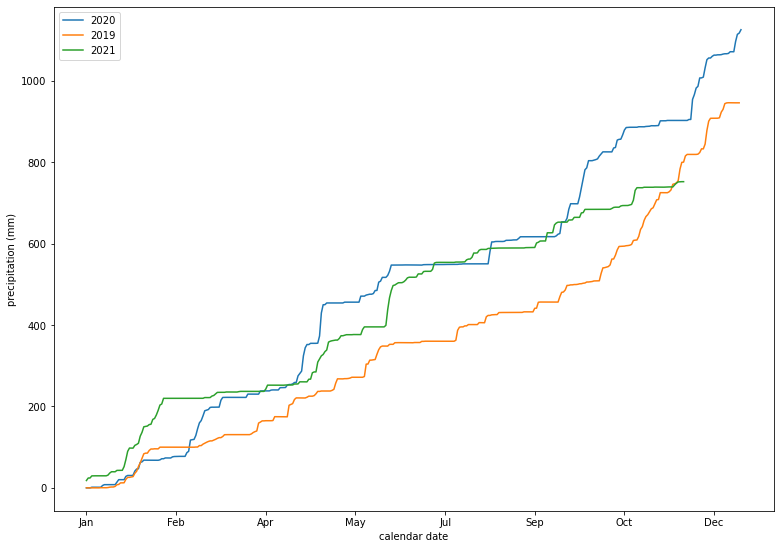

In [206]:
import matplotlib
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10.0, 7.0))
ax = fig.add_axes([0, 0, 1, 1])

def get_total_rainfall(val):
    year, annual_data = val
    total_rainfall = annual_data['rainfall'].cumsum().to_list()[-1]
    return (total_rainfall, year)

for year, annual_data in sorted(rainfall_by_year, key=get_total_rainfall, reverse=True):
    days_since_jan1 = annual_data['days_since_jan1'].to_list()
    rainfall = annual_data['rainfall'].cumsum().to_list()
    ax.plot(days_since_jan1, rainfall, label=year)

# format x axis values as month names rather than days since jan 1st
def format_days_since_jan1(days, pos=None):
    date = datetime.date(2020, 1, 1) + datetime.timedelta(days)
    return date.strftime('%b')
ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(format_days_since_jan1))

# label the axes and title the plot
ax.set_xlabel('calendar date')
ax.set_ylabel('precipitation (mm)')
#ax.set_title('Cumulative Annual Precipitation -"BORDEAUX-MERIGNAC" Station )')

ax.legend()

# save the plot to disk
fig.savefig('cumulative-annual-precipitation-sorted-legend.png', bbox_inches='tight')

## 2. Retrieve Average Air temperatures evolution in the Nouvelle Aquitaine region

This SPARQL query allows to retrieve average air temperature measured at different stations located in the region of Nouvelle Acquitaine (France). 

In [31]:
Qtemp_avg = '''
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX sosa: <http://www.w3.org/ns/sosa/>
PREFIX qudt: <http://qudt.org/schema/qudt/>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
prefix wep: <http://ns.inria.fr/meteo/ontology/property/>
prefix weo: <http://ns.inria.fr/meteo/ontology/>
prefix dct: <http://purl.org/dc/terms/>
prefix wdt: <http://www.wikidata.org/prop/direct/>
prefix wevp: <http://ns.inria.fr/meteo/vocab/weatherproperty/> 

SELECT ?date ?Station (((?temp_min+ ?temp_max)/2) as ?temp_avg)
{
     SELECT ?date ?Station (MIN(?vt) - 273.15 as ?temp_min) (MAX(?vt)- 273.15 as ?temp_max)  
     FROM <http://ns.inria.fr/meteo/observation/2021>
     FROM <http://ns.inria.fr/meteo/weatherstation>
     WHERE      
    {
       { 
            ?obs a  weo:MeteorologicalObservation; sosa:observedProperty wevp:airTemperature;
             sosa:hasSimpleResult ?vt;
             sosa:resultTime ?datetimestamp;
             wep:madeByStation ?x .
             BIND(xsd:date(?datetimestamp) as ?date)
             FILTER exists  { 
                        ?x dct:spatial ?e.                                 
                        ?e wdt:P131 ?item .
                        ?item rdfs:label ?label ; wdt:P2585 ?insee .
                        FILTER (str(?insee)='75')
                                         
         }

    } 
    GRAPH <http://ns.inria.fr/meteo/weatherstation> 
    {
     ?x rdfs:label ?Station ;  weo:stationID ?stationID .
    }
} 

GROUP BY ?date ?Station
ORDER BY ?date
}

'''

In [32]:
df_Qtemp = sparql_to_dataframe(Virtuoso, Qtemp_avg)
df_Qtemp

,date,Station,temp_avg
0,2021-01-01,POITIERS-BIARD,1.1
1,2021-01-01,LIMOGES-BELLEGARDE,0.05
2,2021-01-01,BORDEAUX-MERIGNAC,2.35
3,2021-01-01,PTE DE CHASSIRON,4.25
4,2021-01-01,MONT-DE-MARSAN,4
...,...,...,...
1664,2021-11-30,PTE DE CHASSIRON,7.05
1665,2021-11-30,LIMOGES-BELLEGARDE,1.3
1666,2021-11-30,BORDEAUX-MERIGNAC,6.05
1667,2021-11-30,POITIERS-BIARD,2.45


In [33]:
df_Qtemp['date'] = pd.to_datetime(df_Qtemp.date, format='%Y-%m-%d')
df_Qtemp.temp_avg = df_Qtemp.temp_avg.astype(float)
#df_Qtemp.temp_max = df_Qtemp.temp_max.astype(float)
#df_Qtemp['temp_avgC'] = (df_Qtemp.temp_min + df_Qtemp.temp_max)/2


In [34]:
df_Qtemp.head()

,date,Station,temp_avg
0,2021-01-01,POITIERS-BIARD,1.10
1,2021-01-01,LIMOGES-BELLEGARDE,0.05
2,2021-01-01,BORDEAUX-MERIGNAC,2.35
3,2021-01-01,PTE DE CHASSIRON,4.25
4,2021-01-01,MONT-DE-MARSAN,4.00


In [49]:
df=df_Qtemp.pivot( index ='date' ,columns='Station', values='temp_avg')


In [50]:
df.reset_index()


Station,date,BORDEAUX-MERIGNAC,LIMOGES-BELLEGARDE,MONT-DE-MARSAN,POITIERS-BIARD,PTE DE CHASSIRON
0,2021-01-01,2.35,0.05,4.00,1.10,4.25
1,2021-01-02,0.85,-1.20,1.45,0.35,3.80
2,2021-01-03,3.85,-0.75,3.20,0.60,5.05
3,2021-01-04,1.20,-1.50,3.05,-0.30,2.95
4,2021-01-05,1.20,-0.60,0.90,1.85,3.90
...,...,...,...,...,...,...
329,2021-11-26,6.80,3.15,6.05,7.15,9.20
330,2021-11-27,6.20,3.15,6.10,3.30,8.60
331,2021-11-28,5.70,1.30,4.00,2.85,7.70
332,2021-11-29,4.10,0.20,3.90,1.90,5.80


In [52]:
newdf = df[['BORDEAUX-MERIGNAC', 'LIMOGES-BELLEGARDE', 'POITIERS-BIARD','MONT-DE-MARSAN','PTE DE CHASSIRON' ] ]
newdf = newdf.reset_index()


In [53]:
newdf.dtypes


Station
date                  datetime64[ns]
BORDEAUX-MERIGNAC            float64
LIMOGES-BELLEGARDE           float64
POITIERS-BIARD               float64
MONT-DE-MARSAN               float64
PTE DE CHASSIRON             float64
dtype: object

In [54]:
newdfAJ = newdf.loc[(newdf['date'] >= pd.Timestamp(2021, 4, 1)) & (newdf['date'] <= pd.Timestamp(2021, 6, 30)),: ]



In [55]:
newdfAJ = newdfAJ.set_index('date')


In [56]:
newdfAJ



Station,BORDEAUX-MERIGNAC,LIMOGES-BELLEGARDE,POITIERS-BIARD,MONT-DE-MARSAN,PTE DE CHASSIRON
date,,,,,
2021-04-01,17.55,18.20,16.90,16.85,15.55
2021-04-02,18.15,17.05,14.50,16.35,15.95
2021-04-03,11.75,7.30,8.20,14.00,10.10
2021-04-04,11.35,9.40,9.00,9.45,11.25
2021-04-05,10.50,10.15,7.10,12.80,10.55
...,...,...,...,...,...
2021-06-26,20.20,17.85,19.20,20.80,17.60
2021-06-27,16.40,15.60,16.50,16.75,17.50
2021-06-28,16.70,15.25,15.35,16.85,16.20


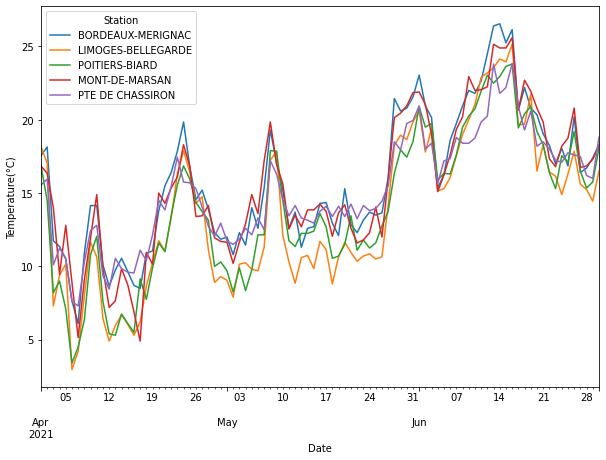

In [58]:
fig2 = newdfAJ.plot(figsize=(10.0, 7.0))
plt.xlabel('Date')
plt.ylabel('Temperature(°C)')
plt.show()

#fig2.savefig('Daily-Average-Temperature.png', bbox_inches='tight')

<ipython-input-59-f43d10063ba4>:110: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


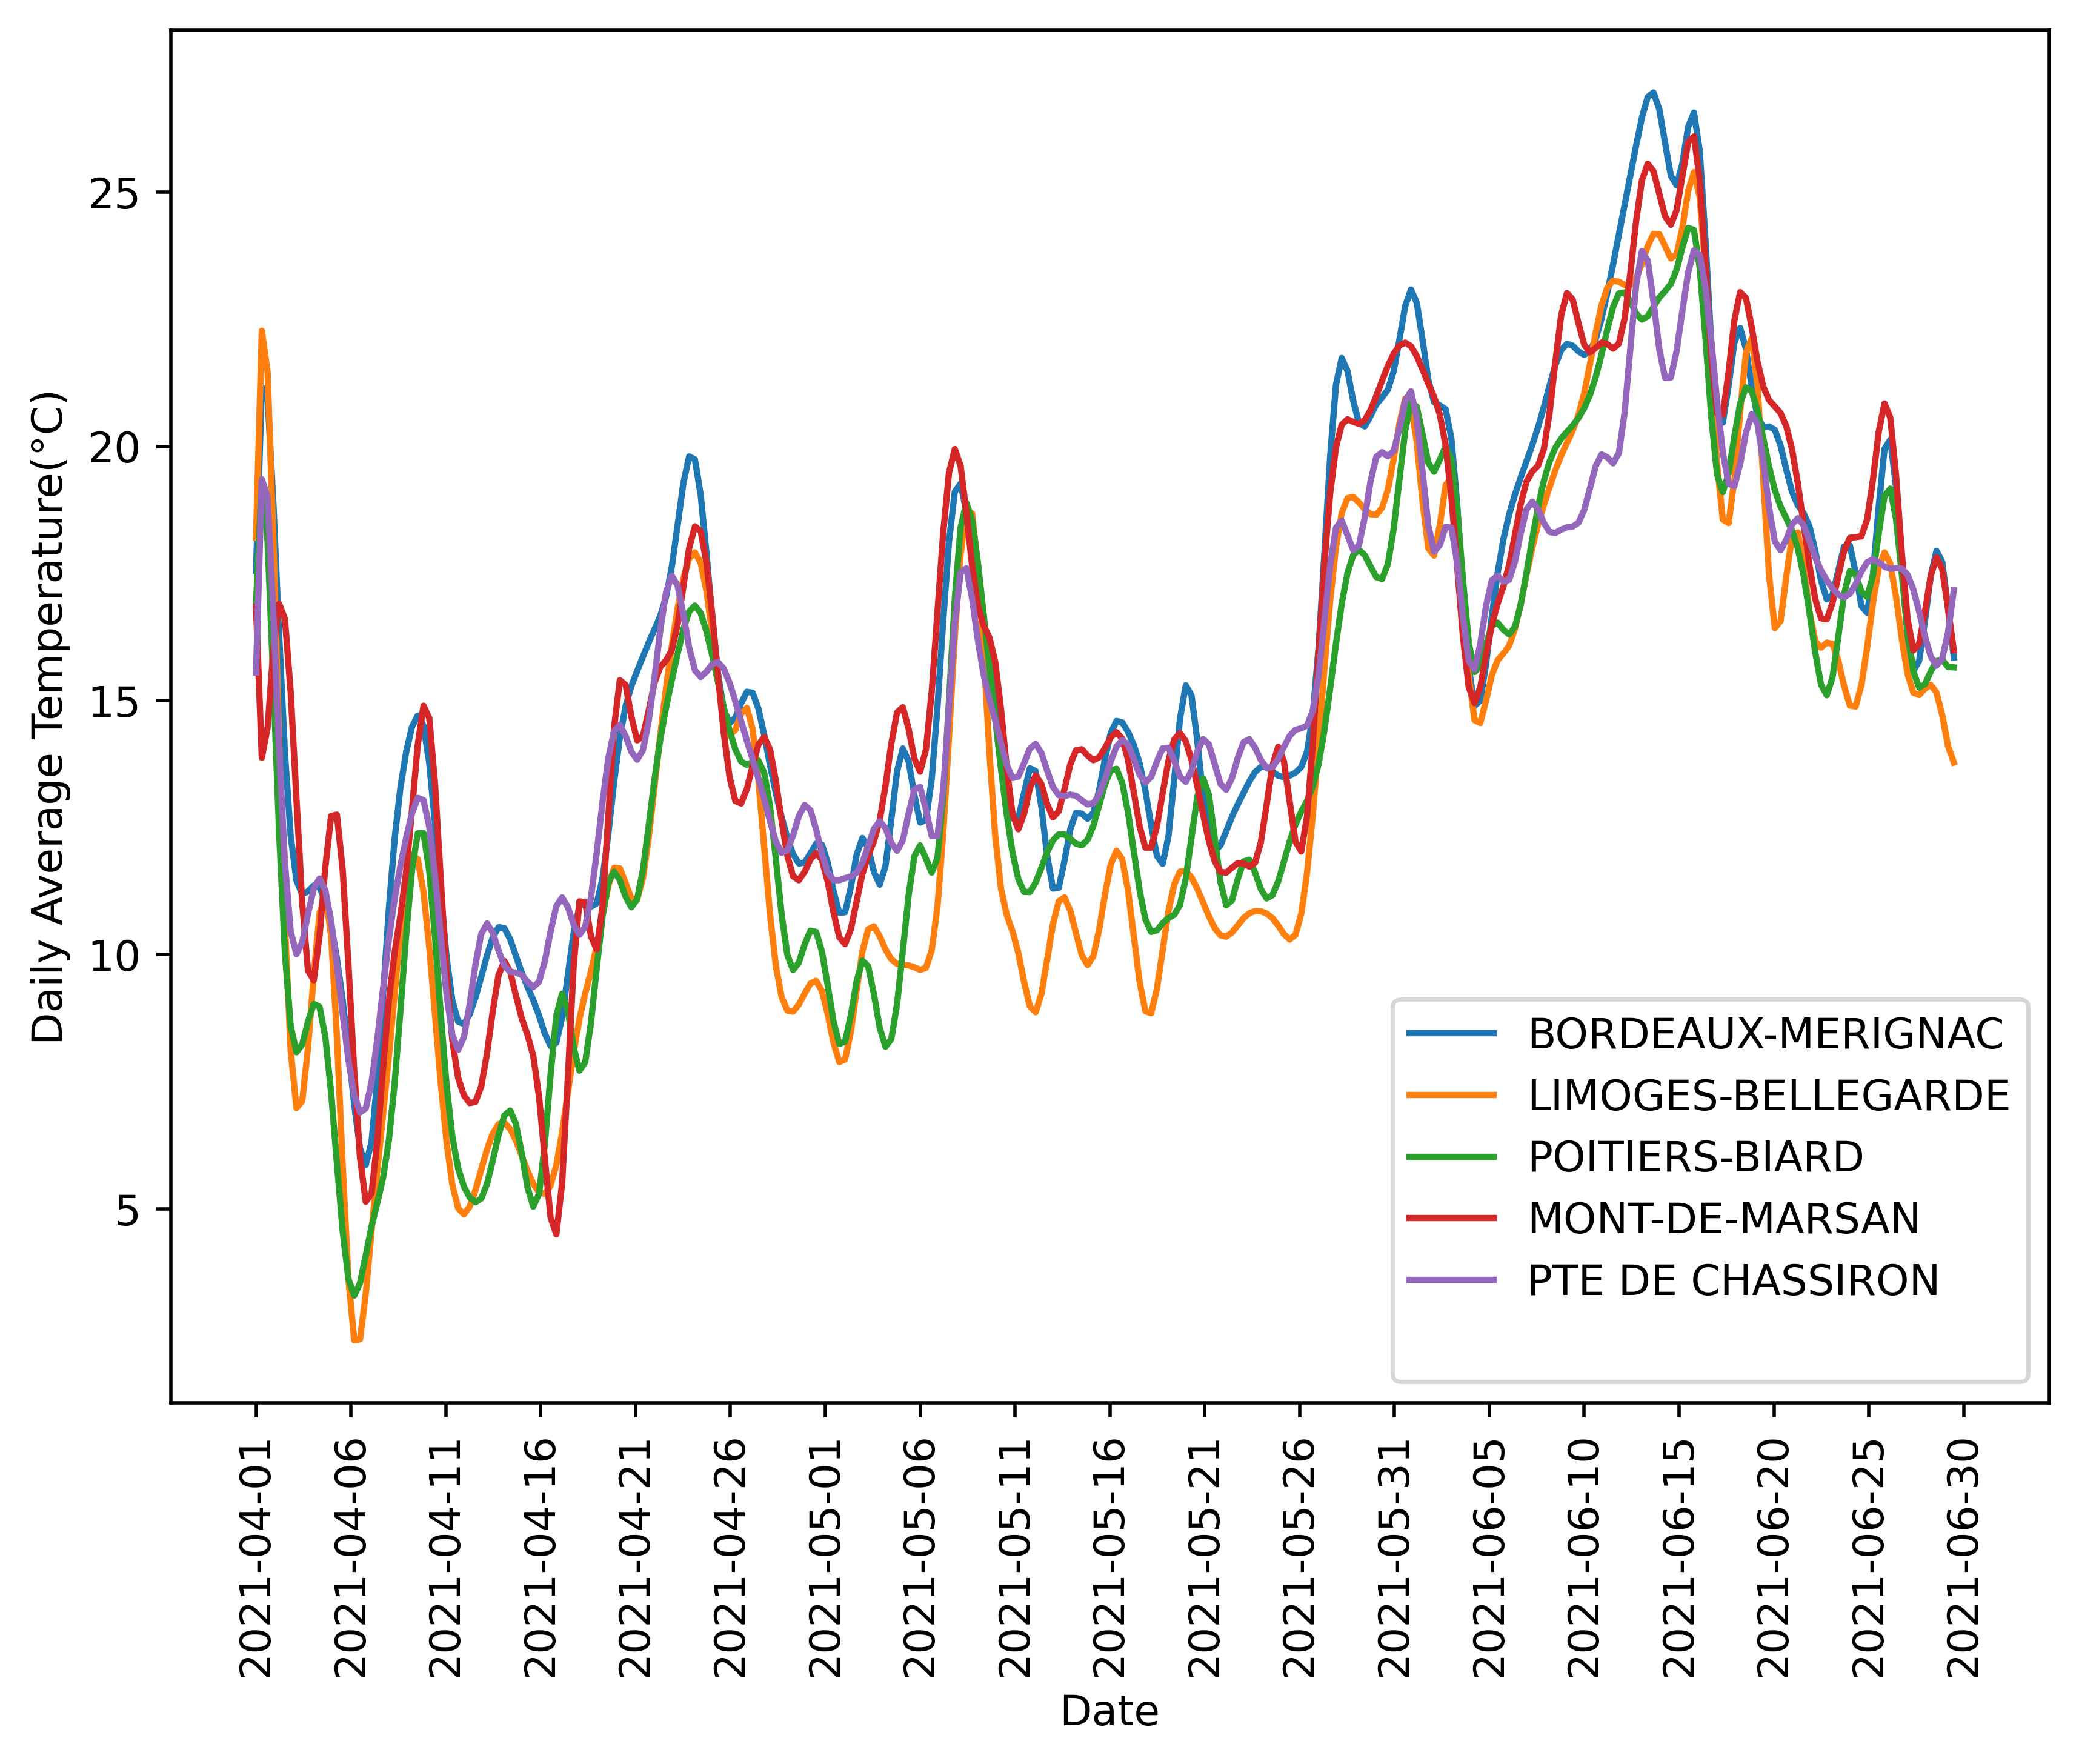

In [59]:
import numpy as np
from scipy.interpolate import make_interp_spline
newdff = newdfAJ.reset_index()
x = np.array(newdff['date'])
y = np.array(newdff['BORDEAUX-MERIGNAC'])
y2 = np.array(newdff['LIMOGES-BELLEGARDE'])
y3 = np.array(newdff['POITIERS-BIARD'])
y4 = np.array(newdff['MONT-DE-MARSAN'])
y5 = np.array(newdff['PTE DE CHASSIRON'])
#df = pd.DataFrame(data, index=index, columns=cols)
fig, axs = plt.subplots(1, 1, figsize=(8, 6), dpi=500)


# workaround by creating linespace for length of your x axis
x_new = np.linspace(0, len(newdff.date), 300)
a_BSpline = make_interp_spline(
    [i for i in range(0, len(newdff.date))],
    newdff['BORDEAUX-MERIGNAC'],
    k=5,
)

a_BSpline = make_interp_spline(
    [i for i in range(0, len(newdff.date))],
    newdff['BORDEAUX-MERIGNAC'],
    k=5,
)



y_new = a_BSpline(x_new)

a_BSpline = make_interp_spline(
    [i for i in range(0, len(newdff.date))],
    newdff['LIMOGES-BELLEGARDE'],
    k=5,
)

y2_new = a_BSpline(x_new)

a_BSpline = make_interp_spline(
    [i for i in range(0, len(newdff.date))],
    newdff['POITIERS-BIARD'],
    k=5,
)

y3_new = a_BSpline(x_new)


a_BSpline = make_interp_spline(
    [i for i in range(0, len(newdff.date))],
    newdff['MONT-DE-MARSAN'],
    k=5,
)

y4_new = a_BSpline(x_new)

a_BSpline = make_interp_spline(
    [i for i in range(0, len(newdff.date))],
    newdff['PTE DE CHASSIRON'],
    k=5,
)

y5_new = a_BSpline(x_new)


# plot this new plot with linestyle = "-"
plt.plot(
    x_new[:-5], # removing last 5 entries to remove noise, because interpolation outputs large values at the end.
    y_new[:-5],
    "-",
    label="BORDEAUX-MERIGNAC"
)

plt.plot(
    x_new[:-5], # removing last 5 entries to remove noise, because interpolation outputs large values at the end.
    y2_new[:-5],
    "-",
    label="LIMOGES-BELLEGARDE"
)

plt.plot(
    x_new[:-5], # removing last 5 entries to remove noise, because interpolation outputs large values at the end.
    y3_new[:-5],
    "-",
    label="POITIERS-BIARD"
)

plt.plot(
    x_new[:-5], # removing last 5 entries to remove noise, because interpolation outputs large values at the end.
    y4_new[:-5],
    "-",
    label="MONT-DE-MARSAN"
)

plt.plot(
    x_new[:-5], # removing last 5 entries to remove noise, because interpolation outputs large values at the end.
    y5_new[:-5],
    "-",
    label="PTE DE CHASSIRON"
)
# to get the date on x axis we will keep our previous plot but linestyle will be None so it won't be visible
x = list(x.astype(str))
x = [s.split('T')[0] for s in x ]
axs.plot(x, y, linestyle=" ", alpha=0.75, label=" ")
xt = [x[i] for i in range(0,len(x),5)]
plt.xlabel('Date')
plt.ylabel('Daily Average Temperature(°C)')
plt.xticks(xt,rotation="vertical")
plt.legend()
fig.show()


In [60]:
df_bordeaux = df_Qtemp[df_Qtemp['Station'] =='BORDEAUX-MERIGNAC' ]

In [61]:
df

Station,BORDEAUX-MERIGNAC,LIMOGES-BELLEGARDE,MONT-DE-MARSAN,POITIERS-BIARD,PTE DE CHASSIRON
date,,,,,
2021-01-01,2.35,0.05,4.00,1.10,4.25
2021-01-02,0.85,-1.20,1.45,0.35,3.80
2021-01-03,3.85,-0.75,3.20,0.60,5.05
2021-01-04,1.20,-1.50,3.05,-0.30,2.95
2021-01-05,1.20,-0.60,0.90,1.85,3.90
...,...,...,...,...,...
2021-11-26,6.80,3.15,6.05,7.15,9.20
2021-11-27,6.20,3.15,6.10,3.30,8.60
2021-11-28,5.70,1.30,4.00,2.85,7.70


In [62]:
df_bordeaux.set_index('date')

,Station,temp_avg
date,,
2021-01-01,BORDEAUX-MERIGNAC,2.35
2021-01-02,BORDEAUX-MERIGNAC,0.85
2021-01-03,BORDEAUX-MERIGNAC,3.85
2021-01-04,BORDEAUX-MERIGNAC,1.20
2021-01-05,BORDEAUX-MERIGNAC,1.20
...,...,...
2021-11-26,BORDEAUX-MERIGNAC,6.80
2021-11-27,BORDEAUX-MERIGNAC,6.20
2021-11-28,BORDEAUX-MERIGNAC,5.70


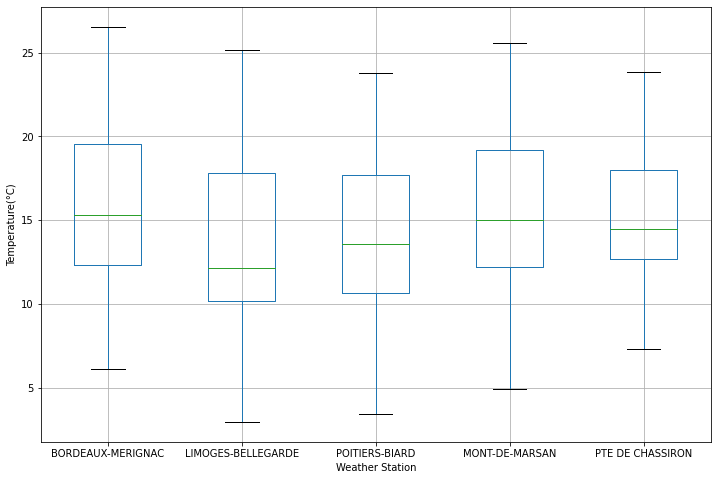

In [64]:

fig2 = newdfAJ.boxplot(figsize=(12.0, 8.0))
plt.xlabel('Weather Station')
plt.ylabel('Temperature(°C)')
plt.show()



In [67]:
query_humidity = '''
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX sosa: <http://www.w3.org/ns/sosa/>
PREFIX qudt: <http://qudt.org/schema/qudt/>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
prefix wep: <http://ns.inria.fr/meteo/ontology/property/>
prefix weo: <http://ns.inria.fr/meteo/ontology/>
prefix dct: <http://purl.org/dc/terms/>
prefix wdt: <http://www.wikidata.org/prop/direct/>
select ?date ?Station (AVG(?vt) as ?humidity)   
FROM <http://ns.inria.fr/meteo/observation/2021>
FROM <http://ns.inria.fr/meteo/weatherstation>
where      {

    { ?obs a  <http://ns.inria.fr/meteo/ontology/MeteorologicalObservation> .
      ?obs sosa:observedProperty <http://ns.inria.fr/meteo/vocab/weatherproperty/airRelativeHumidity>.
      ?obs sosa:hasSimpleResult ?vt.
      ?obs sosa:resultTime ?datetimestamp.
      ?obs wep:madeByStation ?x .
      
       FILTER exists  { 
                        ?x dct:spatial ?e.                                 
                        ?e wdt:P131 ?item .
                        ?item rdfs:label ?label ; wdt:P2585 ?insee .
                        FILTER (str(?insee)='75')
                      }
    
      BIND(xsd:date(?datetimestamp) as ?date)
    } 
GRAPH <http://ns.inria.fr/meteo/weatherstation> 
    {
?x rdfs:label ?Station ;  weo:stationID ?stationID .
}

}
GROUP BY ?date ?Station
'''

In [68]:
HumidityDF = sparql_to_dataframe(Virtuoso, query_humidity)
HumidityDF['date'] = pd.to_datetime(HumidityDF['date'], format='%Y-%m-%d')
HumidityDF.humidity = HumidityDF.humidity.astype(float)
HumidityDF = HumidityDF.sort_values(by='date')
HumidityDF0405= newdf.loc[(newdf['date'] >= pd.Timestamp(2021, 4, 1)) & (newdf['date'] <= pd.Timestamp(2021, 6, 30)),: ]
HumidityDF0405

Station,date,BORDEAUX-MERIGNAC,LIMOGES-BELLEGARDE,POITIERS-BIARD,MONT-DE-MARSAN,PTE DE CHASSIRON
90,2021-04-01,17.55,18.20,16.90,16.85,15.55
91,2021-04-02,18.15,17.05,14.50,16.35,15.95
92,2021-04-03,11.75,7.30,8.20,14.00,10.10
93,2021-04-04,11.35,9.40,9.00,9.45,11.25
94,2021-04-05,10.50,10.15,7.10,12.80,10.55
...,...,...,...,...,...,...
176,2021-06-26,20.20,17.85,19.20,20.80,17.60
177,2021-06-27,16.40,15.60,16.50,16.75,17.50
178,2021-06-28,16.70,15.25,15.35,16.85,16.20
179,2021-06-29,17.40,14.45,15.75,17.30,16.00


In [356]:
HumidityDF=HumidityDF.pivot(index='date', columns='Station', values='humidity')

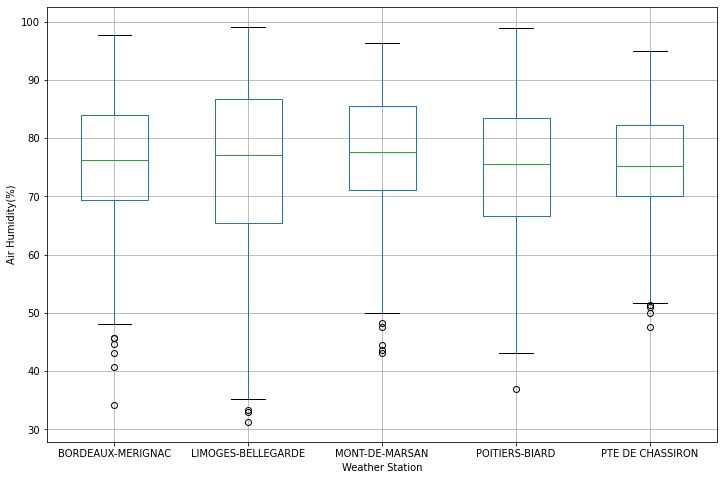

In [357]:
fig2 = HumidityDF.boxplot(figsize=(12.0, 8.0))
plt.xlabel('Weather Station')
plt.ylabel('Air Humidity(%)')
plt.show()